In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

In [10]:
from scipy import stats

## Load Data

In [11]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220901/SIG_atlas_nsw_pad_z0_bkgr_1_BKG_stgBkg20_stgMaxBkgHit1/"
DATA_LOC=f"{SIM}/TEST/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [12]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 200/200 [01:08<00:00,  2.90it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 500000/500000 [00:16<00:00, 30528.07it/s]

!!
I read 500000 events, of which 250000 have muon and 250000 do not
!!


In [13]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

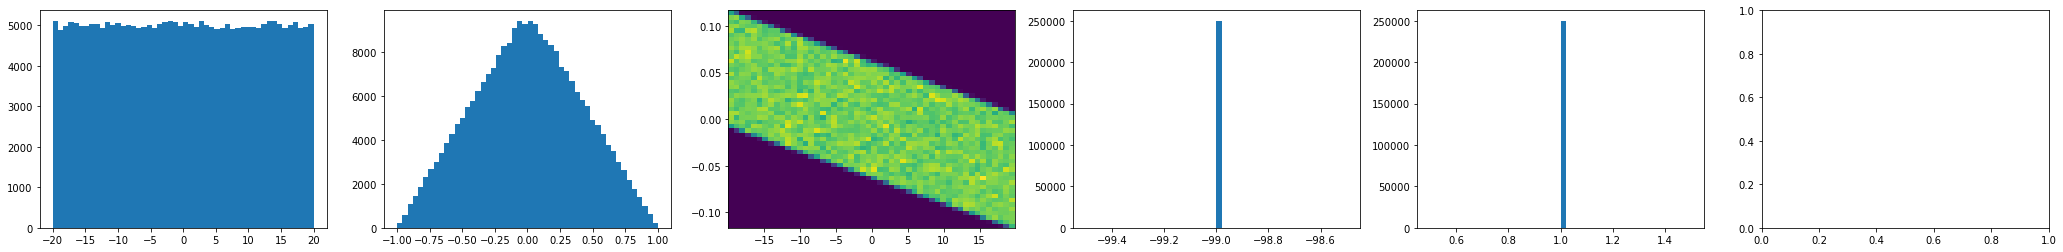

In [14]:
ncols, nrows = (6,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()
axs[0].hist(data['ev_mu_x'][Y_mu==1], bins=50)
axs[1].hist(data['ev_mu_theta'][Y_mu==1]/np.max(data['ev_mu_theta'][Y_mu==1]), bins=50)
axs[2].hist2d(data['ev_mu_x'][Y_mu==1], data['ev_mu_theta'][Y_mu==1], bins=(50,50))

axs[3].hist(data['ev_mu_x'][Y_mu==0], bins=50)
axs[4].hist(data['ev_mu_theta'][Y_mu==0]/np.max(data['ev_mu_theta'][Y_mu==0]), bins=50)

plt.show()

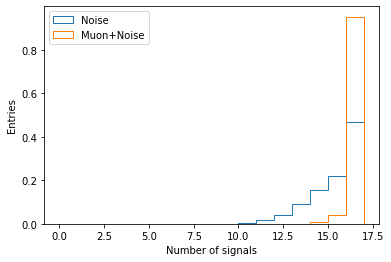

In [15]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], density=1, histtype='step', range=(0,17), bins=17, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], density=1, histtype='step', range=(0,17), bins=17, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

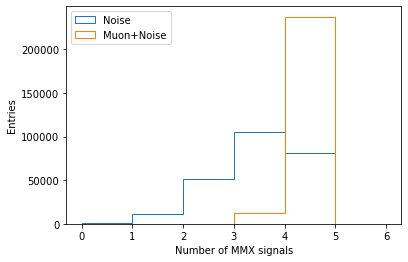

In [16]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

## Define models to compare

In [17]:
import trainingvariables

In [18]:
X_pad = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 500000/500000 [01:20<00:00, 6225.03it/s]

Output data matrix shape: (500000, 20, 20)


In [19]:
detmat=f"{SIM}/atlas_nsw_pad_z0.yml"
X_det = datatools.detector_matrix(dmat, sig_keys, detcard=detmat)

~~ Preparing detector-based data matrix ~~
Using detector card: /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220901/SIG_atlas_nsw_pad_z0_bkgr_1_BKG_stgBkg20_stgMaxBkgHit1//atlas_nsw_pad_z0.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 500000/500000 [01:40<00:00, 4990.20it/s]

Output data matrix shape: (500000, 20, 20)


In [20]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [21]:
import linefit

In [22]:
lfits = linefit.get_fits(dmat, sig_keys)

In [23]:
lfits

array([[ 2.53902709e-02, -1.13514215e+01,  3.08754602e+03],
       [ 8.24500573e-03,  2.52865088e+00,  4.97666697e+03],
       [-2.00277241e-02, -4.15619237e+00,  9.88581144e+03],
       ...,
       [-1.56584786e-02,  2.72273548e+00,  1.49932576e+04],
       [-1.60741264e-03, -1.04561829e+00,  4.78472920e+04],
       [ 9.87415295e-03,  2.87364600e+00,  3.99683575e+04]])

In [24]:
lfits_mu = linefit.get_fits(dmat, sig_keys, is_perfect=True, only_x=False)

In [25]:
lfits_theta = np.arctan(lfits[:,0])
lfits_mu_theta = np.arctan(lfits_mu[:,0])

In [26]:
# lfits_theta[np.arctan(lfits[:,0])<0] = -(lfits_theta[np.arctan(lfits[:,0])<0] + np.pi/2 )
# lfits_theta[np.arctan(lfits[:,0])>0] = -(lfits_theta[np.arctan(lfits[:,0])>0] - np.pi/2 )

# lfits_mu_theta[np.arctan(lfits_mu[:,0])<0] = -(lfits_mu_theta[np.arctan(lfits_mu[:,0])<0] + np.pi/2 )
# lfits_mu_theta[np.arctan(lfits_mu[:,0])>0] = -(lfits_mu_theta[np.arctan(lfits_mu[:,0])>0] - np.pi/2 )

In [27]:
lfits_theta

array([ 0.02538482,  0.00824482, -0.02002505, ..., -0.0156572 ,
       -0.00160741,  0.00987383])

In [28]:
mod_list = [

["403",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat"],
["203",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.6"],
["383",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.3"],
["203",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.2"],
["203",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat"],
["403",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_10"],
["203",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.7"],
["203",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.3"],
["383",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.1"],
["383",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat"],
["383",  "../sep5_models/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_0.5"],
    
]
mdict = {}

for imod,mod in enumerate(mod_list):
    
    m_name = str(imod)+'_'+str(mod[0]) + '_'
    m_name += 'flat' if 'Flatten' in mod[1] else 'avg'
    m_name += 'DET' if 'DetMat' in mod[1] else ''
    
    mdict[m_name] = {
        "loc": mod[1],
        "color": f"C{len(mdict)+2}",
        "x_reg_out": 1,
        "a_reg_out": 2
    }
    

In [29]:
for mod in mdict:
    
    if 'yhat' in mdict[mod].keys():
        print("Already added this model")
        continue
    
    if 'DET' in mod:
        X_prep = X_det
    else:
        X_prep = X_pad
        
    
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    mdict[mod]['x'] = X_prep[:,:,vars_of_interest]
    mdict[mod]['x_keys'] = np.array(sig_keys)[vars_of_interest]
    
    model = keras.models.load_model(mdict[mod]['loc'],compile=False)
    
    preds = model.predict(mdict[mod]['x'], batch_size=1024)
    
    mdict[mod]['yhat'] = sigmoid(preds[:,0]) if linearized else preds[:,0]
    
    mult_fact = max(data['ev_mu_x'])
    mult_facta = max(data['ev_mu_theta'])
    
    all_weights = np.array([])
    for layer in model.layers:
        for w in layer.weights:
            all_weights = np.concatenate( [w.numpy().flatten(), all_weights] )
    all_weights[ np.abs(all_weights) < 2**-25] = 2**-25
    mdict[mod]['nweights'] = all_weights
    
    if 'x_reg_out' in mdict[mod]:
        mdict[mod]['x_reg'] = preds[:,mdict[mod]['x_reg_out']]*mult_fact
        
    if 'a_reg_out' in mdict[mod]:
        mdict[mod]['a_reg'] = preds[:,mdict[mod]['a_reg_out']]*mult_facta

## Make plots

<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02579227  0.01533794 -0.01483111 ... -0.0406253   0.01310371
  0.02358979]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02121518  0.01452833 -0.03021039 ... -0.04138065  0.01300226
  0.02327324]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02622956  0.01342105 -0.024057   ... -0.04278176  0.01383696
  0.02227956]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02155682  0.01483903 -0.02975777 ... -0.04103028  0.01287474
  0.02339928]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02070476  0.01402876 -0.03055875 ... -0.04087624  0.01271025
  0.02230057]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.0258486   0.01537975 -0.01477893 ... -0.04057924  0.01316237
  0.02363873]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02134101  0.01463923 -0.03013828 ... -0.04129744  0.01300222
  0.02347366]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02170579  0.01501644 -0.02957931 ... -0.04094407  0.01320306
  0.02361382]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.0263935   0.01347707 -0.02400491 ... -0.04255729  0.01461334
  0.02224797]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.02667705  0.01435774 -0.02374887 ... -0.04220373  0.01410656
  0.0226618 ]


<ipython-input-30-6536ba7511cc>:28: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')


[ 0.0265723   0.01403418 -0.02370744 ... -0.04242331  0.01451138
  0.02263858]


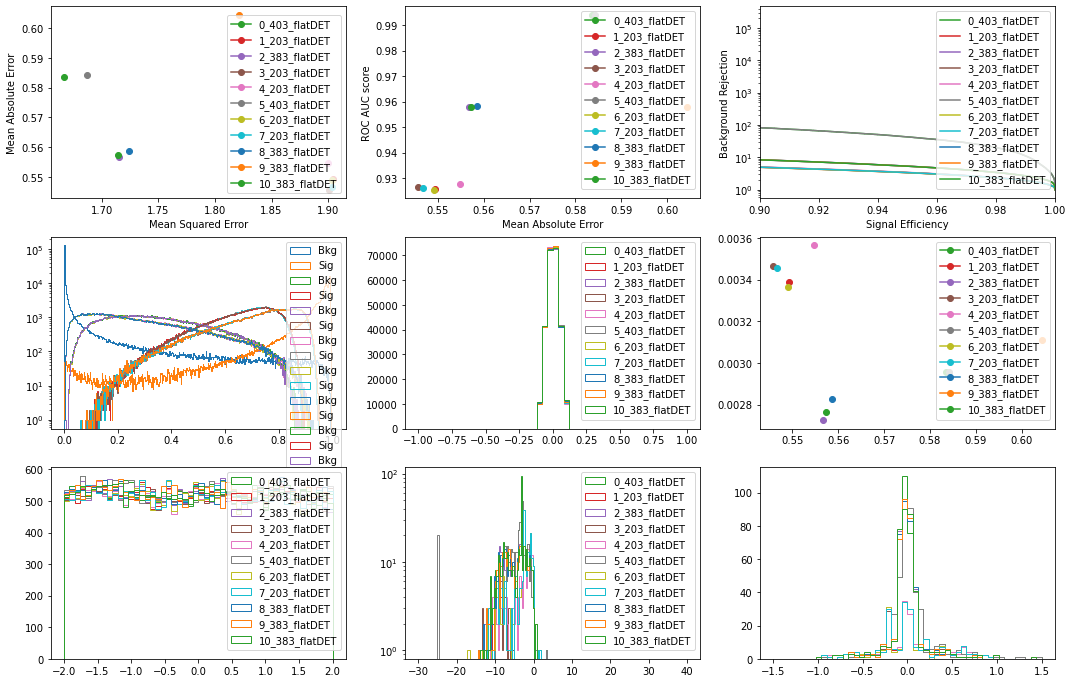

In [30]:
ncols, nrows = (3,3)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

this_cut=(Y_mu==1)

chi2_mse = metrics.mean_squared_error( data['ev_mu_x'][this_cut], lfits[this_cut][:,1] )
chi2_mae = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits[this_cut][:,1] )

# axs.plot(chi2_mse, chi2_mae, marker='+', label='Chi 2')

# chi2mu_mse = metrics.mean_squared_error( data['ev_mu_x'][this_cut], lfits_mu[this_cut][:,1] )
# chi2mu_mae = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], lfits_mu[this_cut][:,1] )

# axs.plot(chi2mu_mse, chi2mu_mae, label='Chi 2 (mu)')

for mod in mdict:
    
    mod_mse = metrics.mean_squared_error( data['ev_mu_x'][this_cut], mdict[mod]['x_reg'][this_cut] )
    mod_mae = metrics.mean_absolute_error( data['ev_mu_x'][this_cut], mdict[mod]['x_reg'][this_cut] )
    mod_auc = metrics.roc_auc_score( Y_mu, mdict[mod]['yhat'] )
    fpr, tpr, thresholds = metrics.roc_curve( Y_mu, mdict[mod]['yhat'] )
    
    axs[0].plot((mod_mse), mod_mae, marker='o', color=mdict[mod]['color'], label=f'{mod}')
    
    axs[1].plot(mod_mae, mod_auc, marker='o', color=mdict[mod]['color'], label=f'{mod}')
    
    axs[2].semilogy(tpr, 1./fpr, color=mdict[mod]['color'], label=f'{mod}')
    
    axs[3].hist( mdict[mod]['yhat'][Y_mu==0], histtype='step', bins=500, range=(0,1), label='Bkg' )
    axs[3].hist( mdict[mod]['yhat'][Y_mu==1], histtype='step', bins=500, range=(0,1), label='Sig' )
    
    if 'a_reg' in mdict[mod]:
        axs[4].hist( mdict[mod]['a_reg'][Y_mu==1], bins=50, range=(-1,1), histtype='step', color=mdict[mod]['color'], label=f'{mod}' )
        print(mdict[mod]['a_reg'][Y_mu==1])
        
        moda_mae = metrics.mean_absolute_error( data['ev_mu_theta'][this_cut], mdict[mod]['a_reg'][this_cut] )
        
        axs[5].plot(mod_mae, moda_mae, marker='o', color=mdict[mod]['color'], label=f'{mod}')
        
    if 'x_reg' in mdict[mod]:
        axs[6].hist( mdict[mod]['x_reg'][Y_mu==1], bins=50, range=(-2,2), histtype='step', color=mdict[mod]['color'], label=f'{mod}' )
        
    axs[7].hist( np.log2(np.abs(mdict[mod]['nweights'])), histtype='step', bins=200, range=(-30,40), color=mdict[mod]['color'], label=f'{mod}' )
    axs[8].hist( mdict[mod]['nweights'] , histtype='step', bins=50, range=(-1.5,1.5), color=mdict[mod]['color'], label=f'{mod}' )

axs[0].set_xlabel("Mean Squared Error")
axs[0].set_ylabel("Mean Absolute Error")

axs[1].set_xlabel("Mean Absolute Error")
axs[1].set_ylabel("ROC AUC score")

axs[2].set_xlabel("Signal Efficiency")
axs[2].set_ylabel("Background Rejection")

axs[0].legend(loc='lower right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[3].legend(loc='upper right')
axs[4].legend(loc='upper right')
axs[5].legend(loc='upper right')
axs[6].legend(loc='upper right')
axs[7].legend(loc='upper right')
axs[7].set_yscale('log')
# axs[8].set_yscale('log')
axs[2].set_xlim(0.9,1)

axs[3].set_yscale('log')

# plt.savefig("plots/scores.pdf")
plt.show()

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


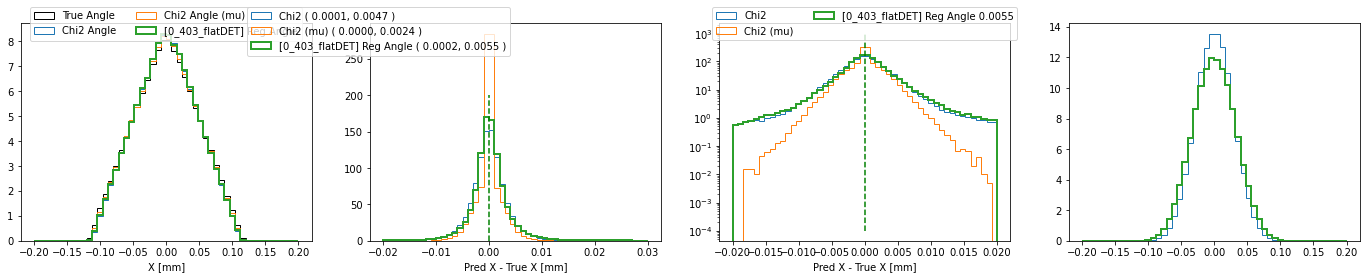

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


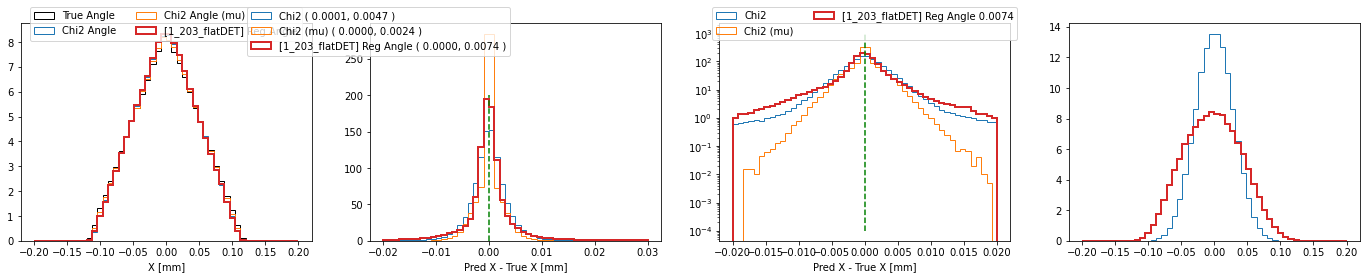

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


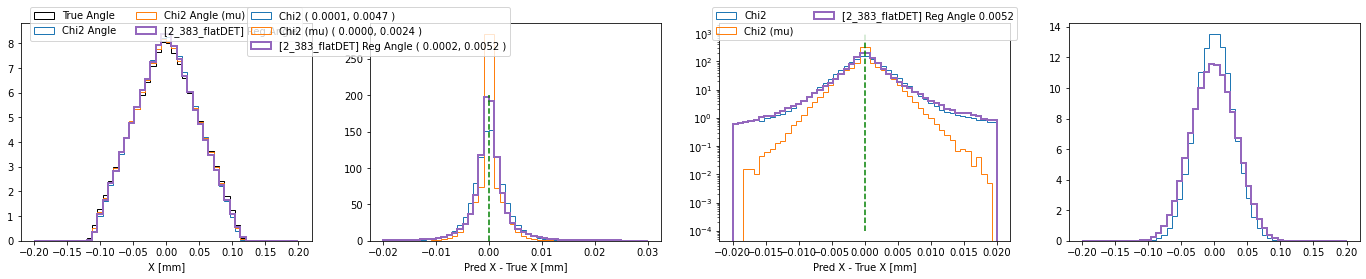

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


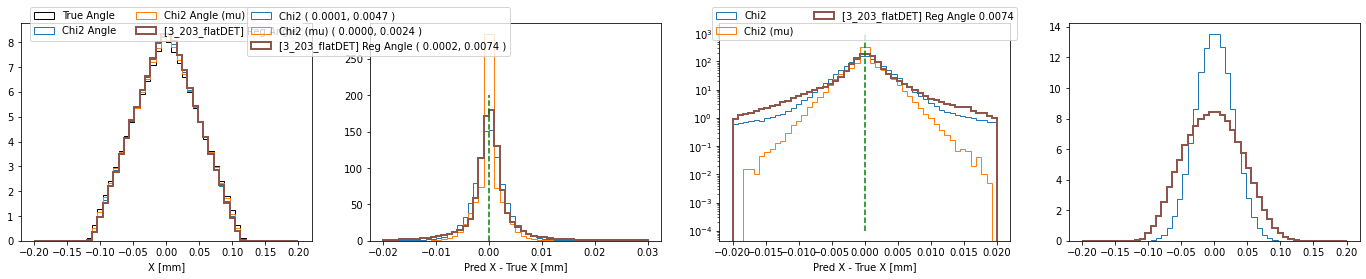

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


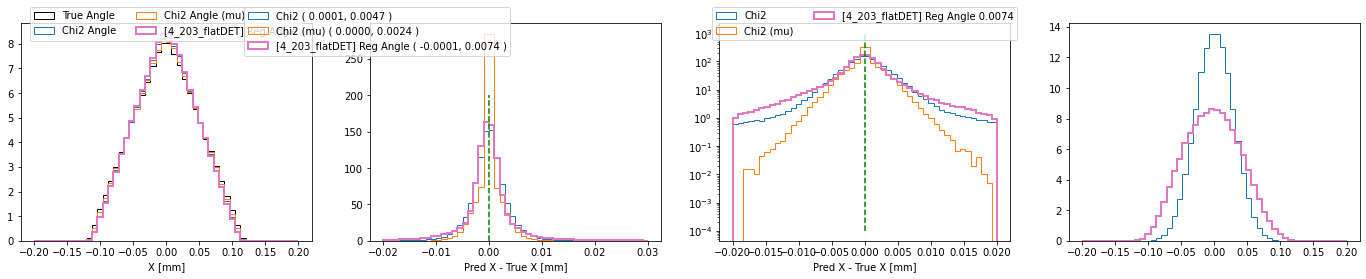

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


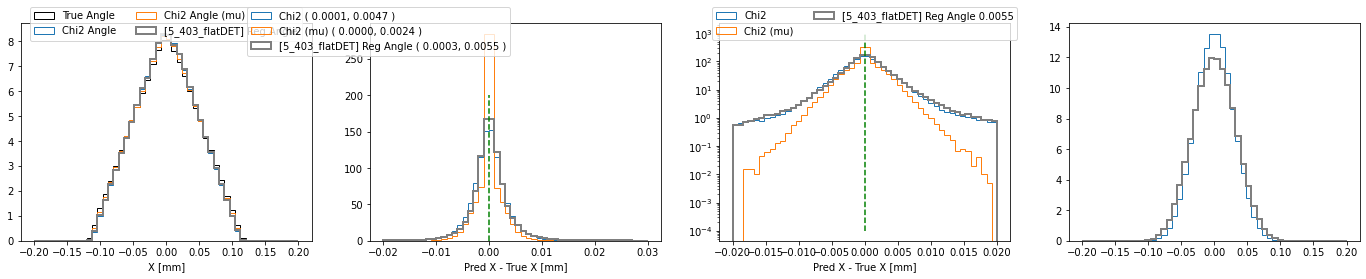

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


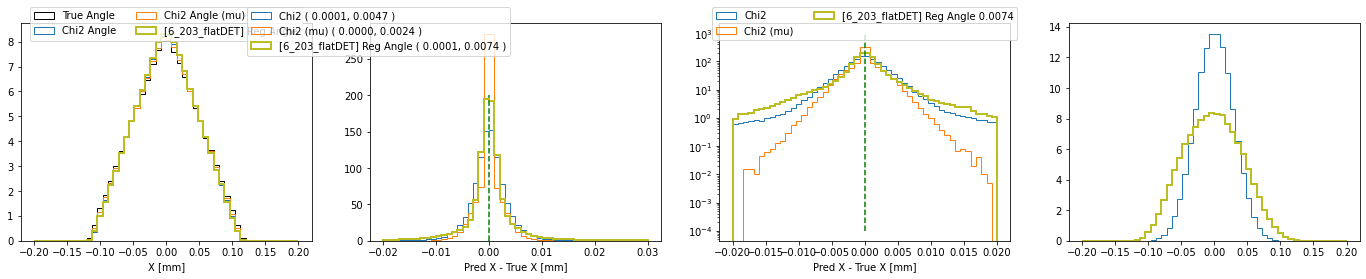

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


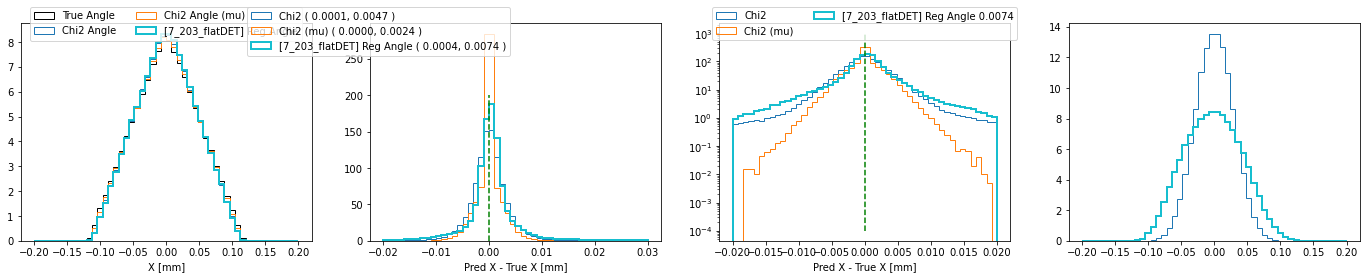

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


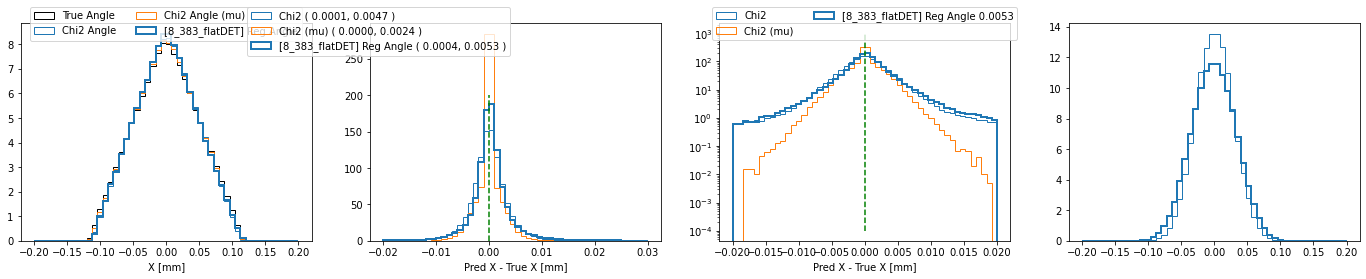

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


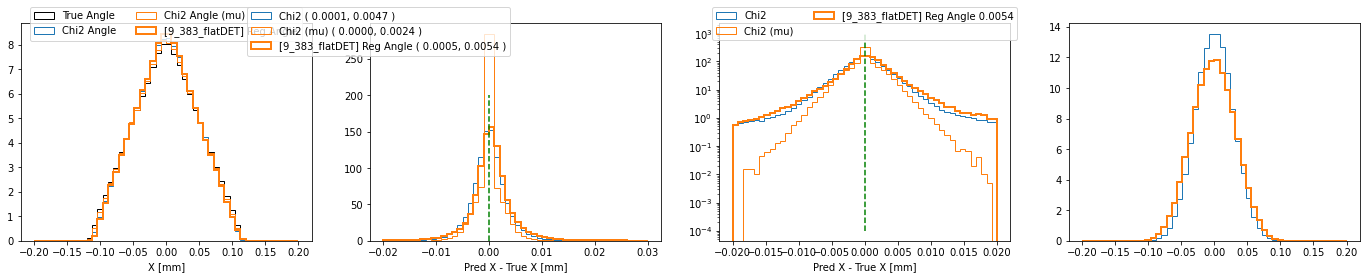

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


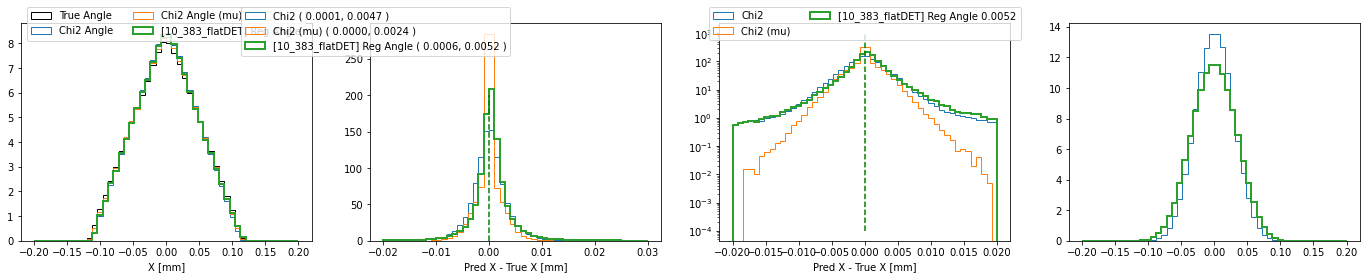

In [31]:
this_cut=(Y_mu==1)

norm_fit_chi2 = stats.norm.fit(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1])
norm_fit_chi2mu = stats.norm.fit(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1])

for mod in mdict:

    if 'a_reg' not in mdict[mod]: continue
    
    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    axs[0].hist(data['ev_mu_theta'][this_cut], histtype='step', range=(-0.2,0.2), density=1, color='black',
                bins=50, label=f'True Angle')

    axs[0].hist(lfits_theta[this_cut], histtype='step', range=(-0.2,0.2), density=1, color='C0',
                bins=50, label=f'Chi2 Angle')

    axs[0].hist(lfits_mu_theta[this_cut], histtype='step', range=(-0.2,0.2), density=1, color='C1',
                bins=50, label=f'Chi2 Angle (mu)')
    

    axs[1].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.02,0.03), density=1, color='C0',
                bins=50, label=f'Chi2 ( {norm_fit_chi2[0]:.4f}, {norm_fit_chi2[1]:.4f} )')

    axs[1].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.02,0.03), density=1, color='C1',
                bins=50, label=f'Chi2 (mu) ( {norm_fit_chi2mu[0]:.4f}, {norm_fit_chi2mu[1]:.4f} )')

    axs[2].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.02,0.02), density=1, color='C0',
                bins=50, label=f'Chi2')

    axs[2].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1], histtype='step', range=(-0.02,0.02), density=1, color='C1',
                bins=50, label=f'Chi2 (mu)')

    axs[3].hist(lfits_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C0',
                bins=50, label=f'Chi2 Angle')

    axs[3].hist(lfits_mu_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C1',
                bins=50, label=f'Chi2 Angle (mu)')
        
    if True:
        areg=mdict[mod]['a_reg']
        axs[0].hist(areg[this_cut], histtype='step', range=(-0.2,0.2), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)

        norm_fit_mod = stats.norm.fit(areg[this_cut] - data['ev_mu_theta'][Y_mu==1])
        axs[1].hist(areg[this_cut] - data['ev_mu_theta'][Y_mu==1], 
                    histtype='step', range=(-0.02,0.03), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle ( {norm_fit_mod[0]:.4f}, {norm_fit_mod[1]:.4f} )', linewidth=2)

        this_std = (areg[this_cut] - data['ev_mu_theta'][Y_mu==1]).std()
        axs[2].hist(areg[this_cut] - data['ev_mu_theta'][Y_mu==1], 
                    histtype='step', range=(-0.02,0.02), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle {this_std:.4f}', linewidth=2)
        
        axs[3].hist(areg[Y_mu==0], 
                    histtype='step', range=(-0.2,0.2), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}] Reg Angle', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=1, loc='upper right', bbox_to_anchor=(0.5, 1.1))
    # axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    
    axs[1].plot([0,0], [1e-4, 200], 'g--')
    axs[2].plot([0,0], [1e-4, 1e3], 'g--')
    plt.show()

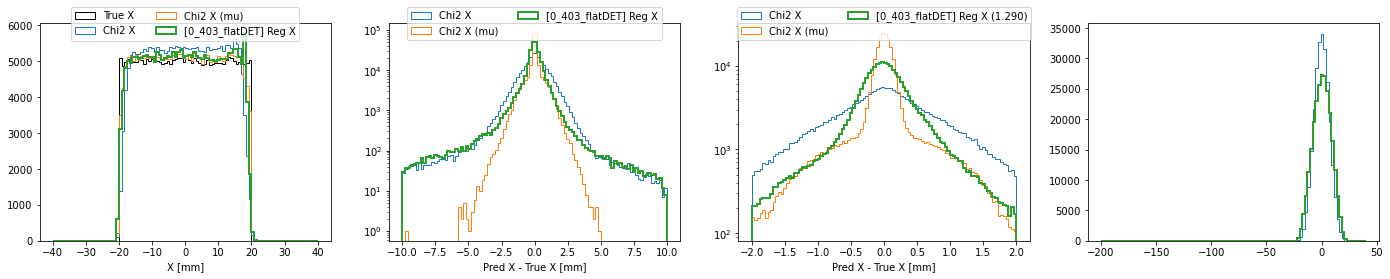

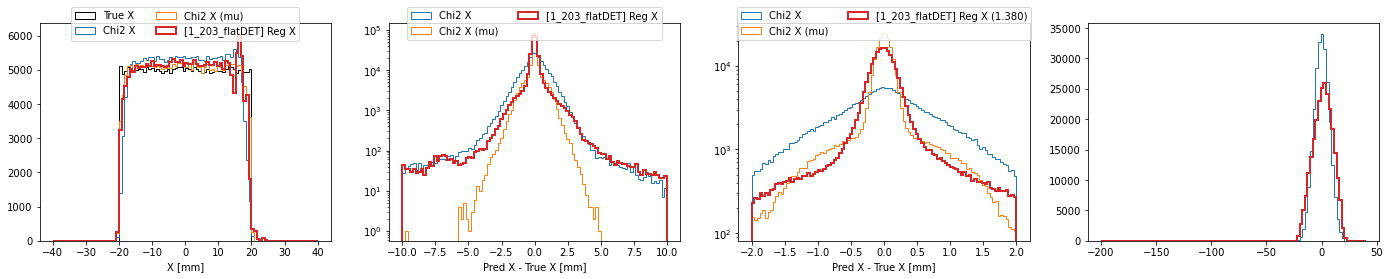

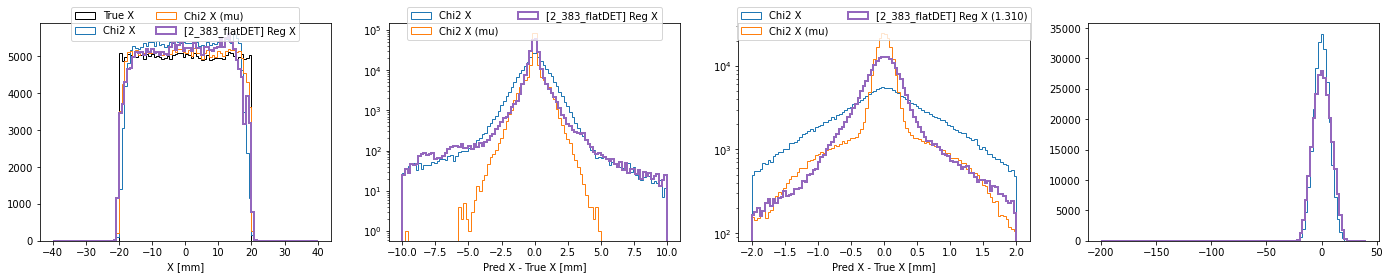

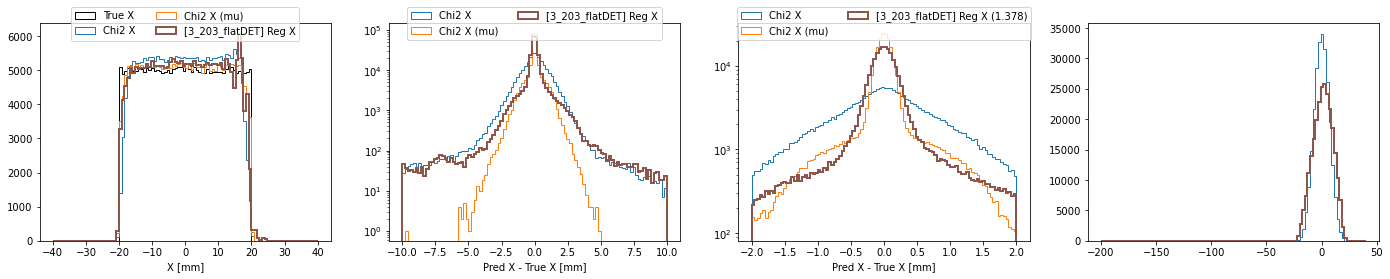

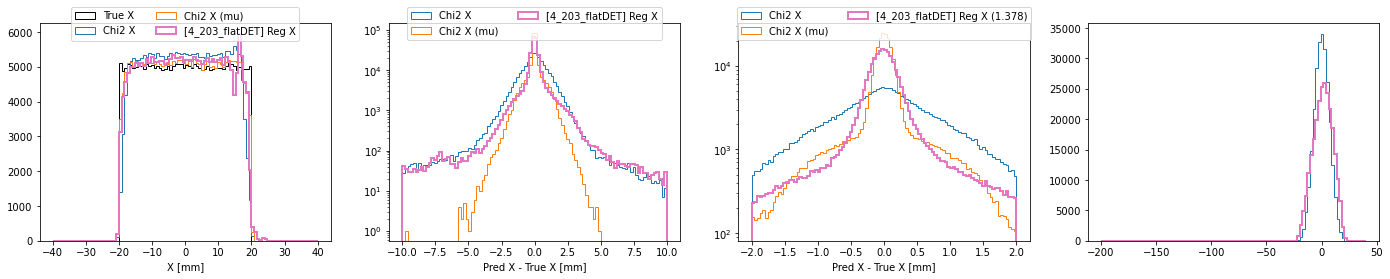

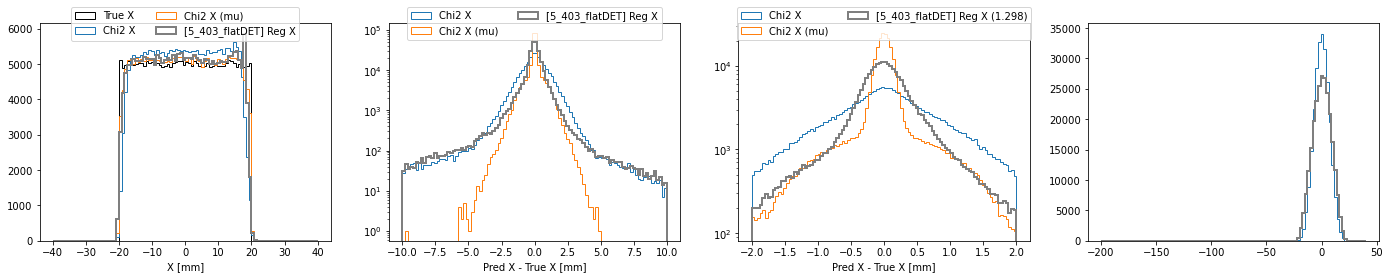

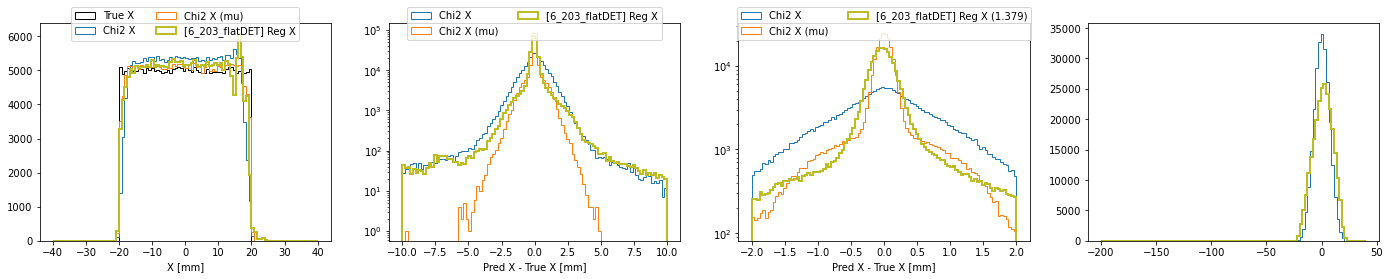

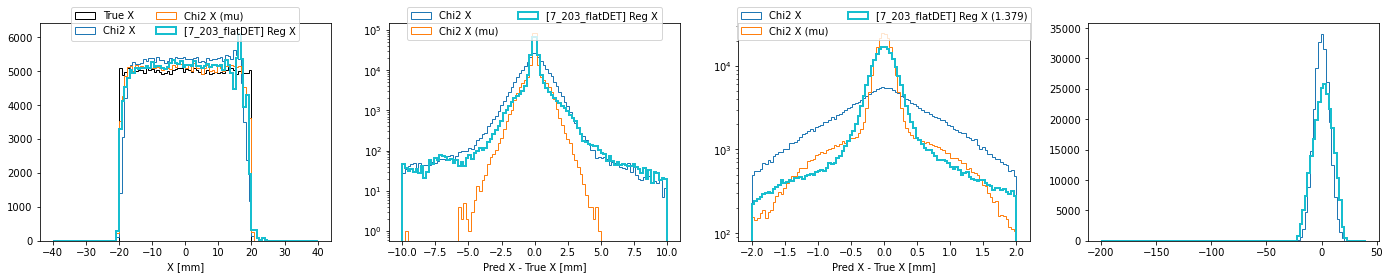

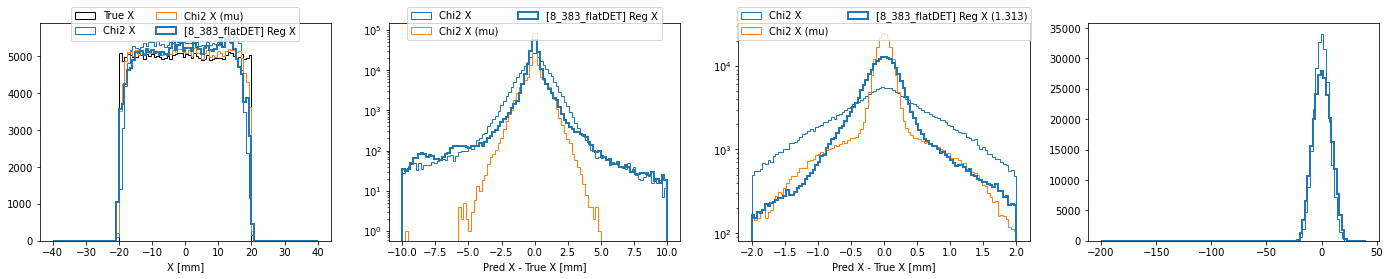

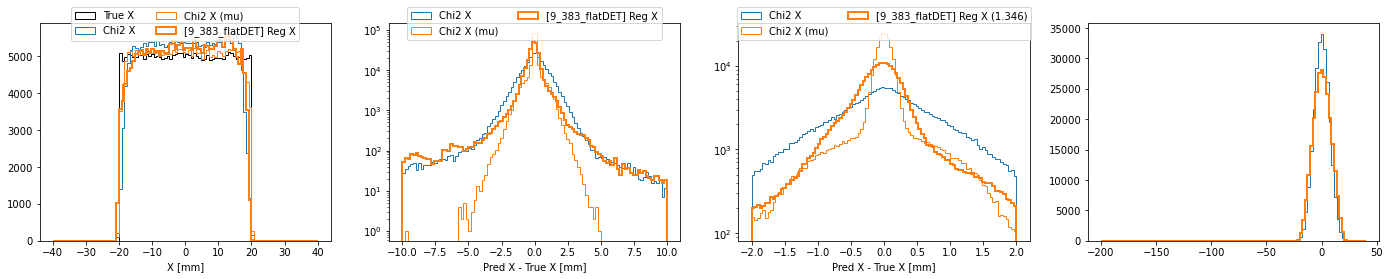

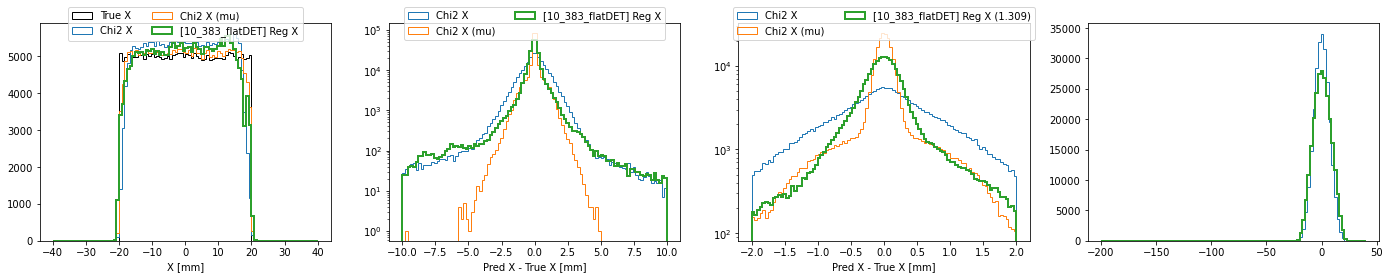

In [32]:
for mod in mdict:


    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)


    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=100, label=f'True X')

    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
                bins=100, label=f'Chi2 X')

    axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C0',
                bins=100, label=f'Chi2 X')

    axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C0',
                bins=100, label=f'Chi2 X')

    axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C1',
                bins=100, label=f'Chi2 X (mu)')

    axs[3].hist(lfits[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C0',
                bins=100, label=f'Chi2 X')

    axs[3].hist(lfits_mu[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C1',
                bins=100, label=f'Chi2 X (mu)')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-10,10), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        this_std = (xreg[this_cut] - data['ev_mu_x'][Y_mu==1]).std()
        axs[2].hist(xreg[this_cut] - data['ev_mu_x'][Y_mu==1], 
                    histtype='step', range=(-2,2), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X ({this_std:.3f})', linewidth=2)
        
        axs[3].hist(xreg[Y_mu==0], 
                    histtype='step', range=(-200,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

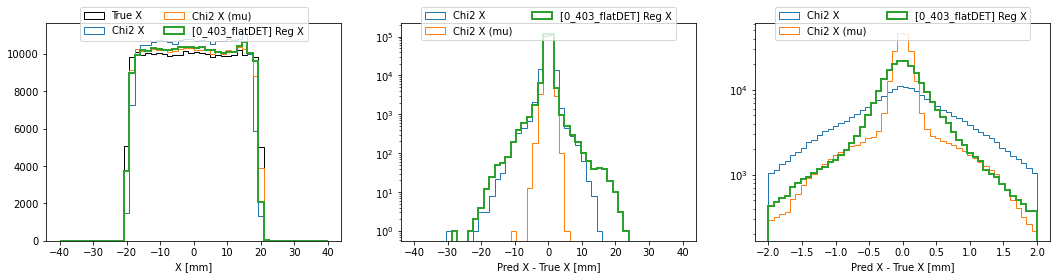

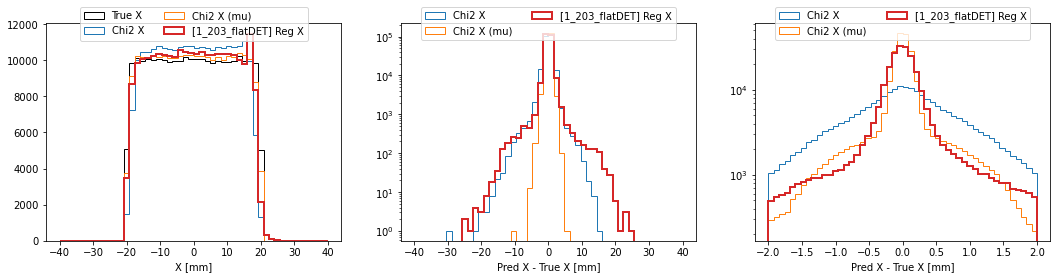

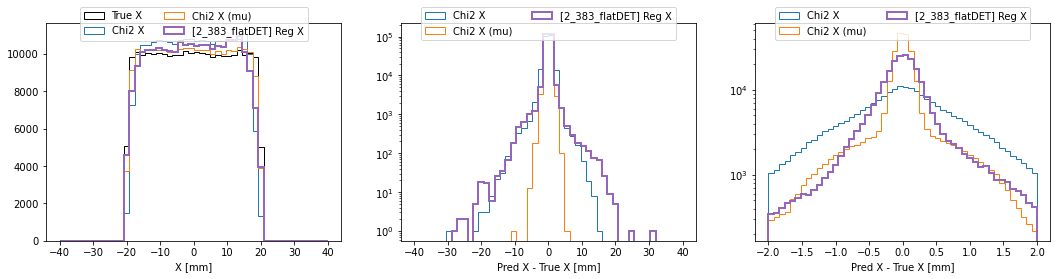

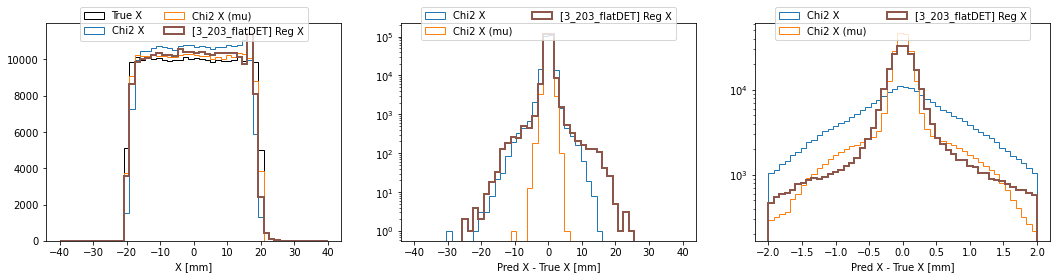

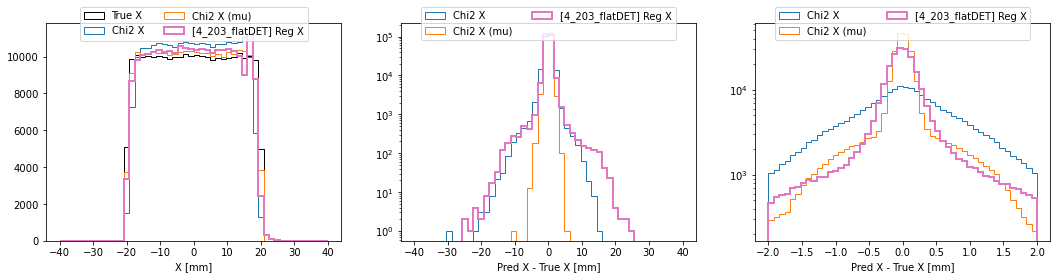

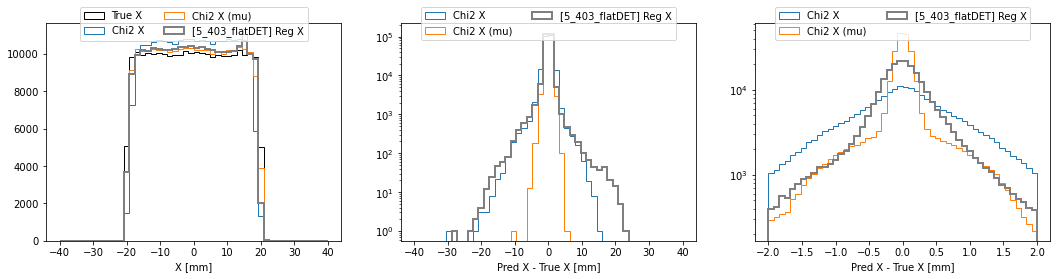

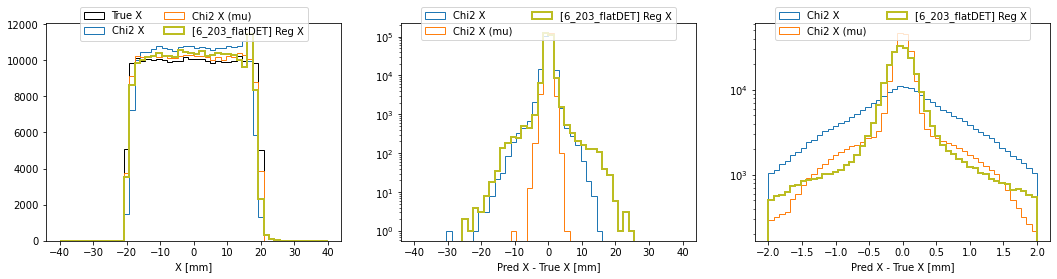

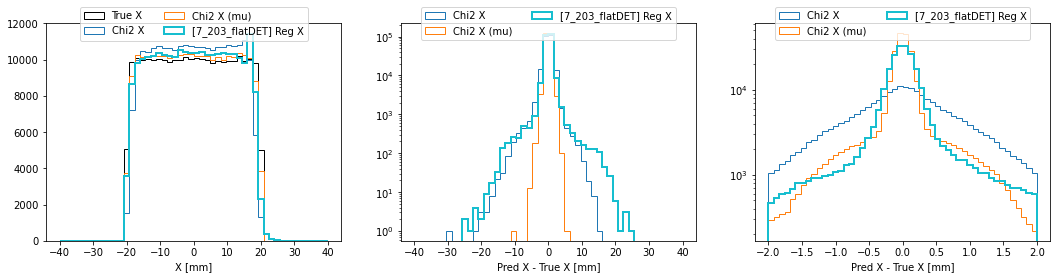

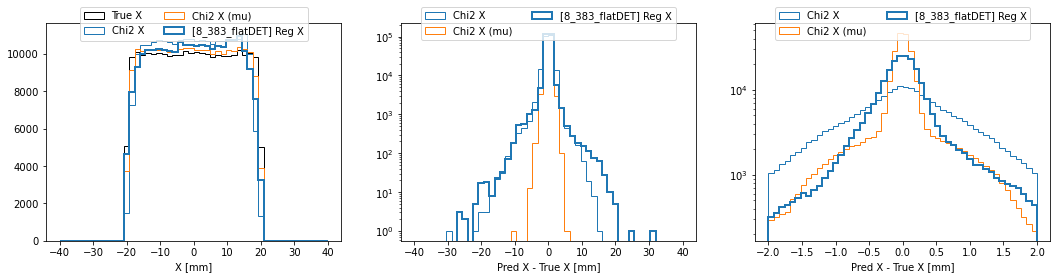

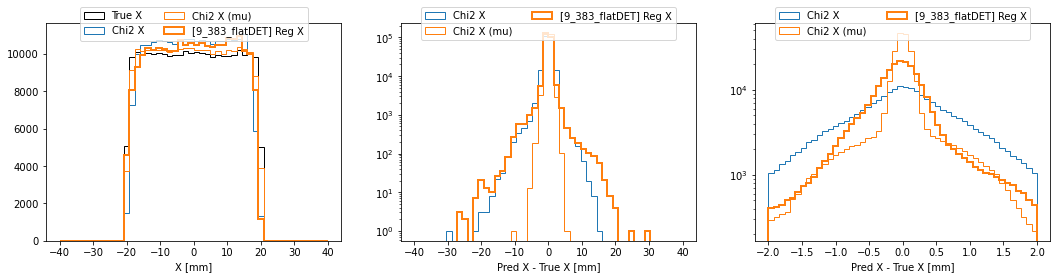

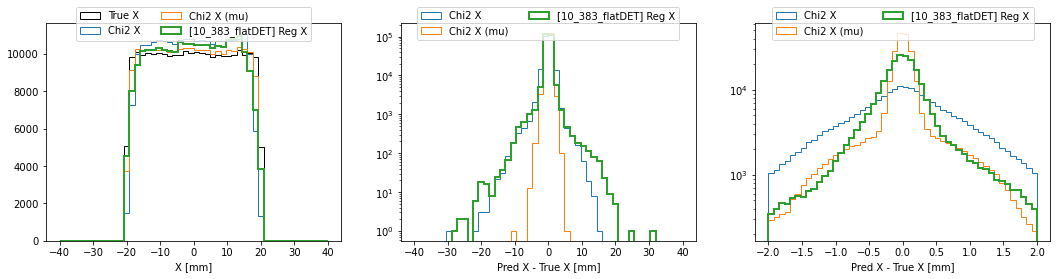

In [33]:
for mod in mdict:


    ncols, nrows = (3,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)*(data['ev_n_mu_signals']>7)


    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=50, label=f'True X')

    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
                bins=50, label=f'Chi2 X')

    axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
                bins=50, label=f'Chi2 X (mu)')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='C0',
                bins=50, label=f'Chi2 X')

    axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-40,40), color='C1',
                bins=50, label=f'Chi2 X (mu)')

    axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-2,2), color='C0',
                bins=50, label=f'Chi2 X')

    axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-2,2), color='C1',
                bins=50, label=f'Chi2 X (mu)')

    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
                    histtype='step', range=(-40,40), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[2].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
                    histtype='step', range=(-2,2), bins=50, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

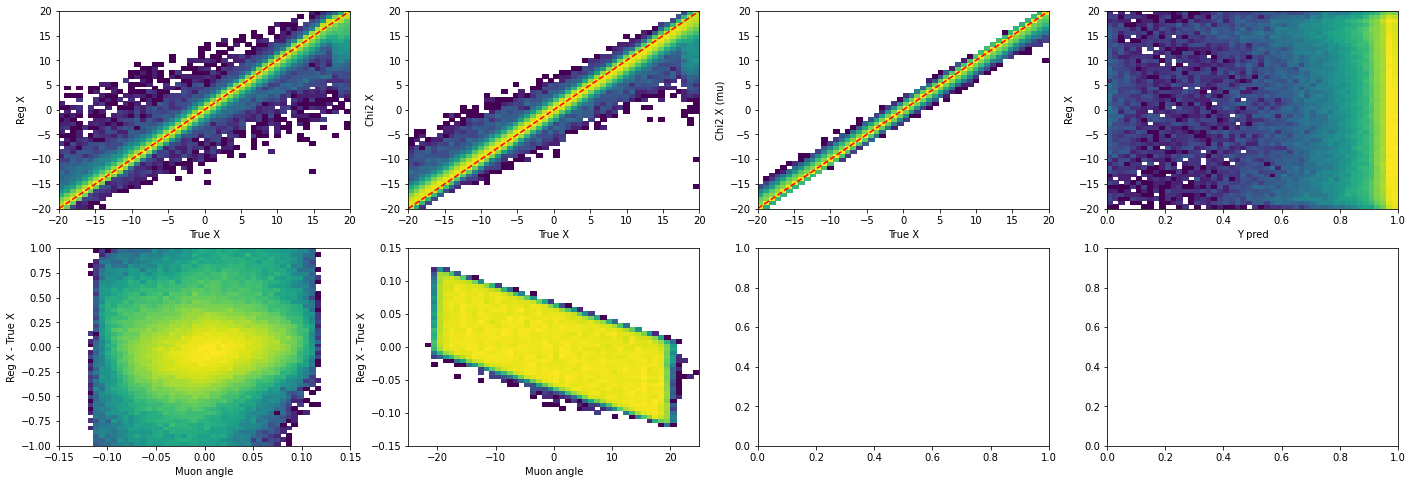

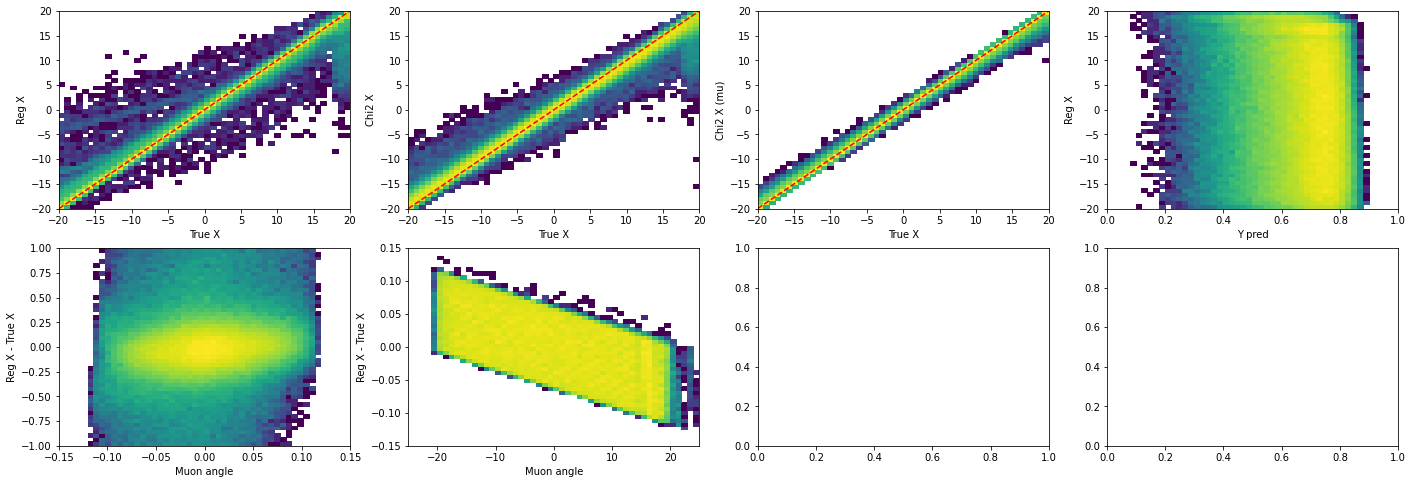

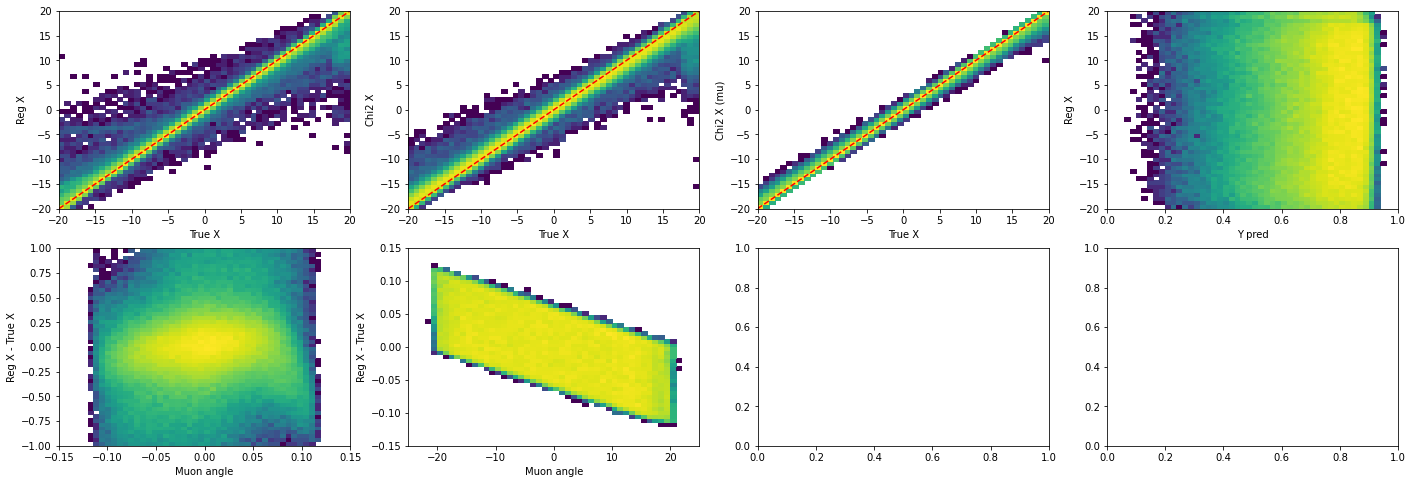

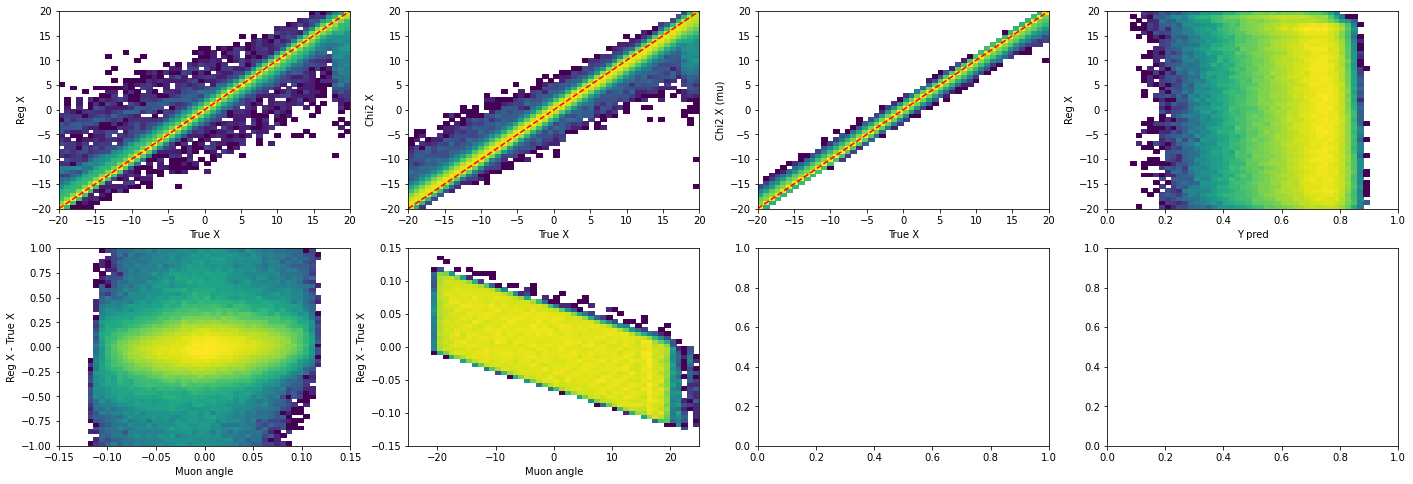

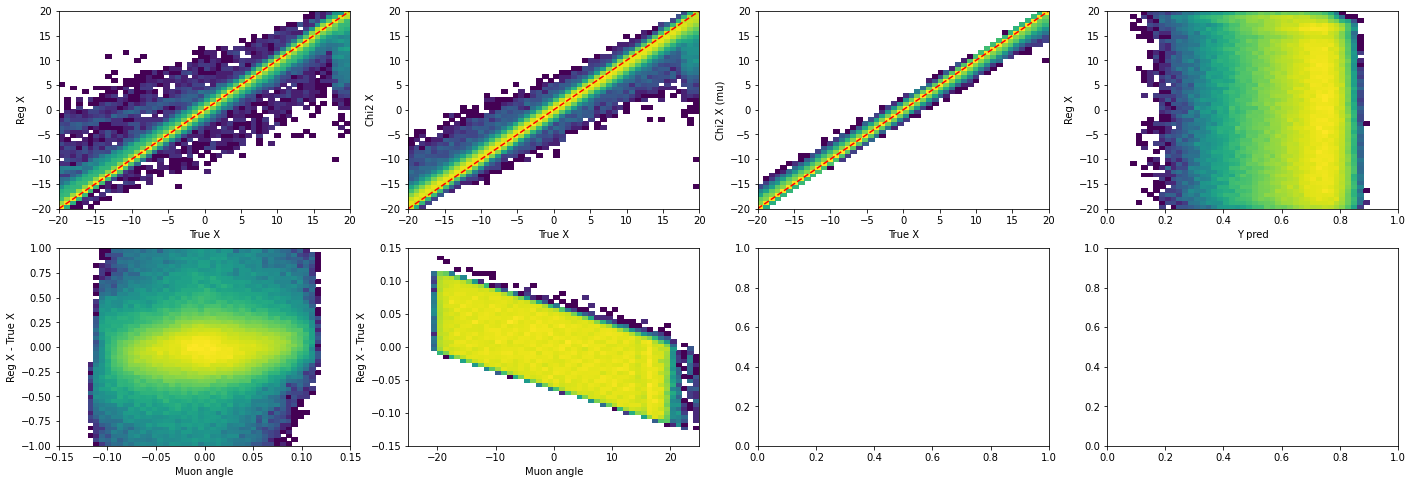

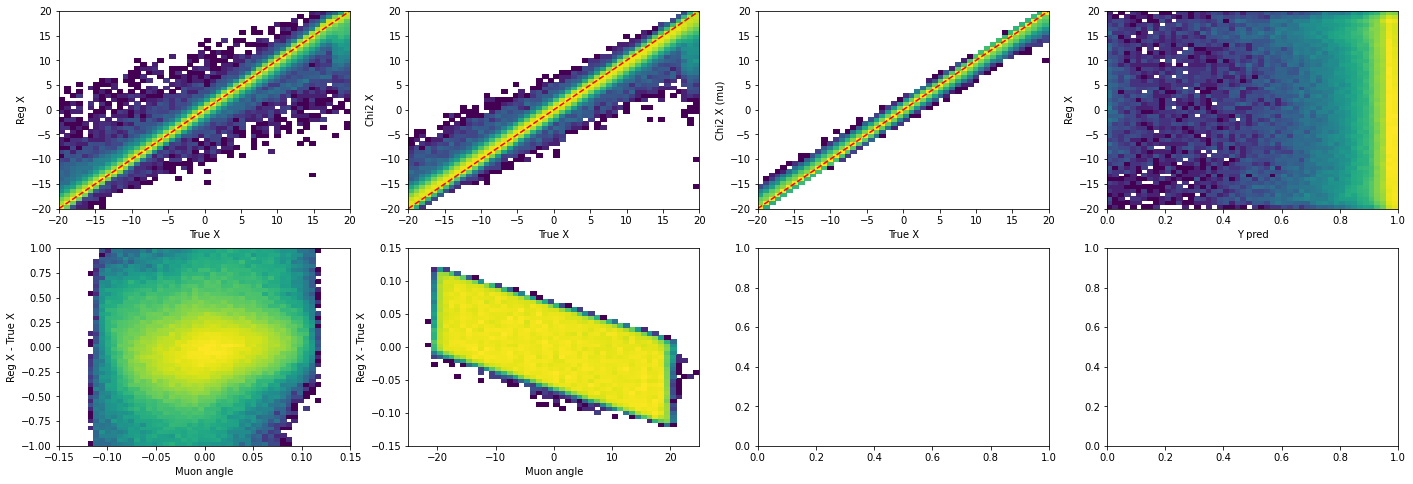

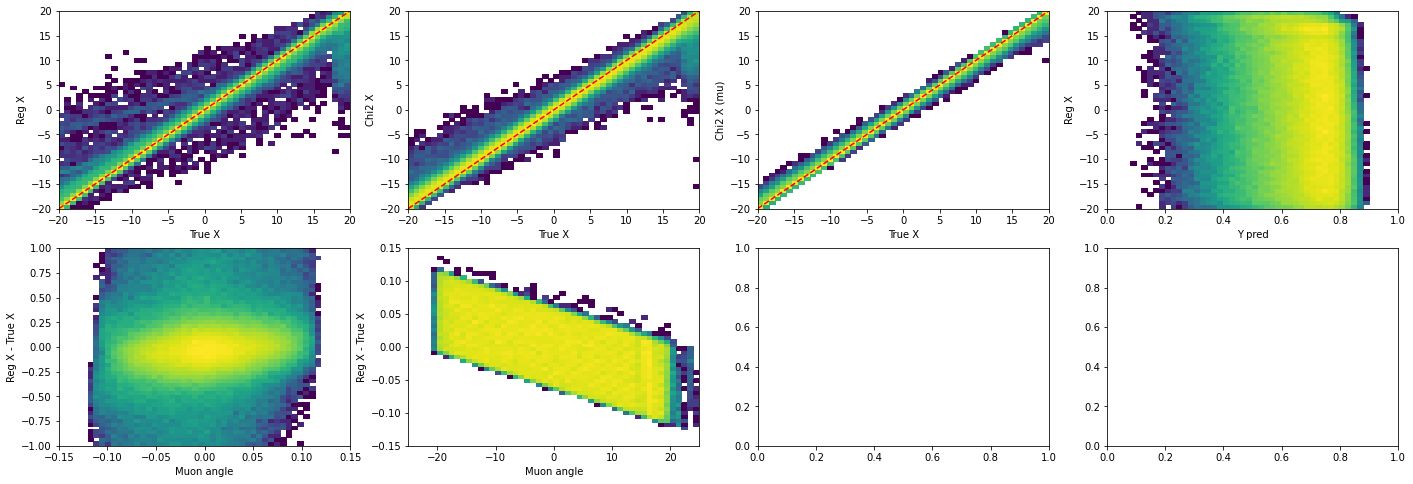

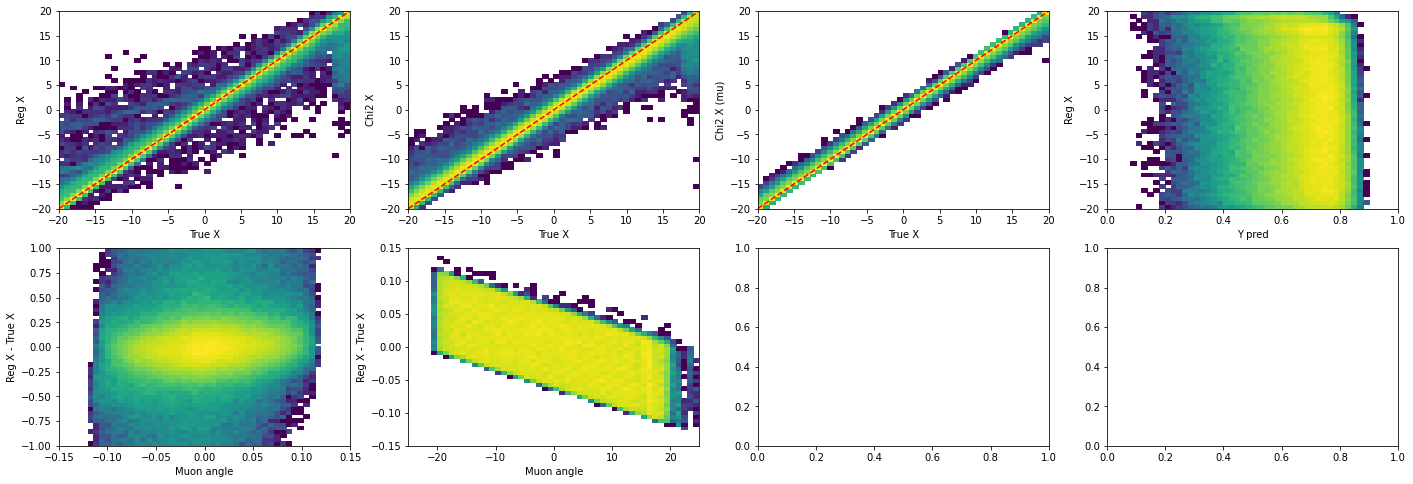

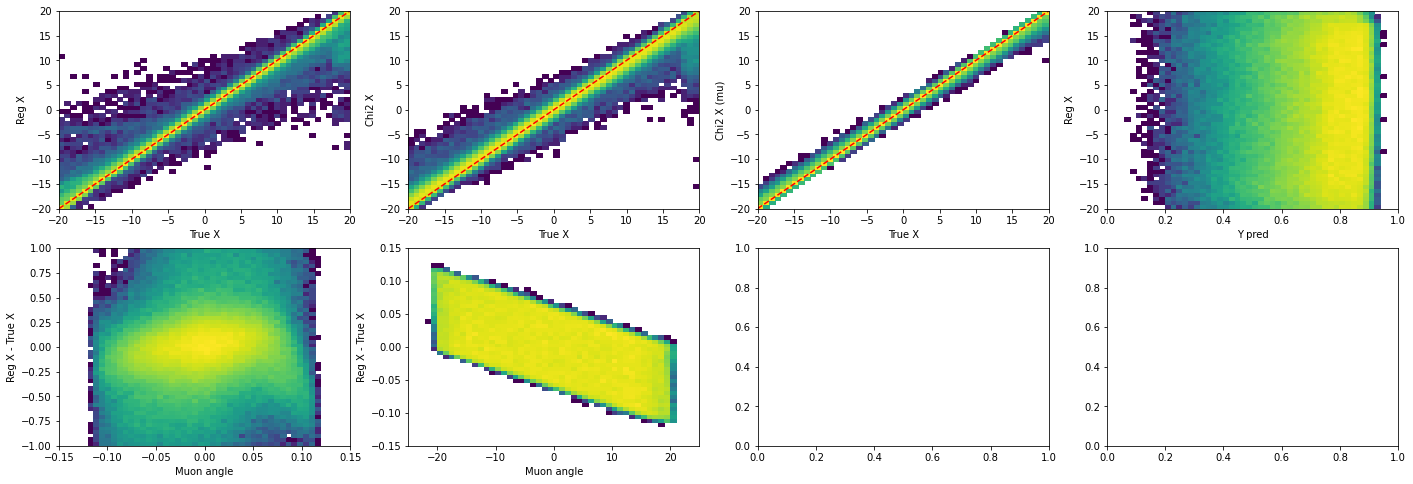

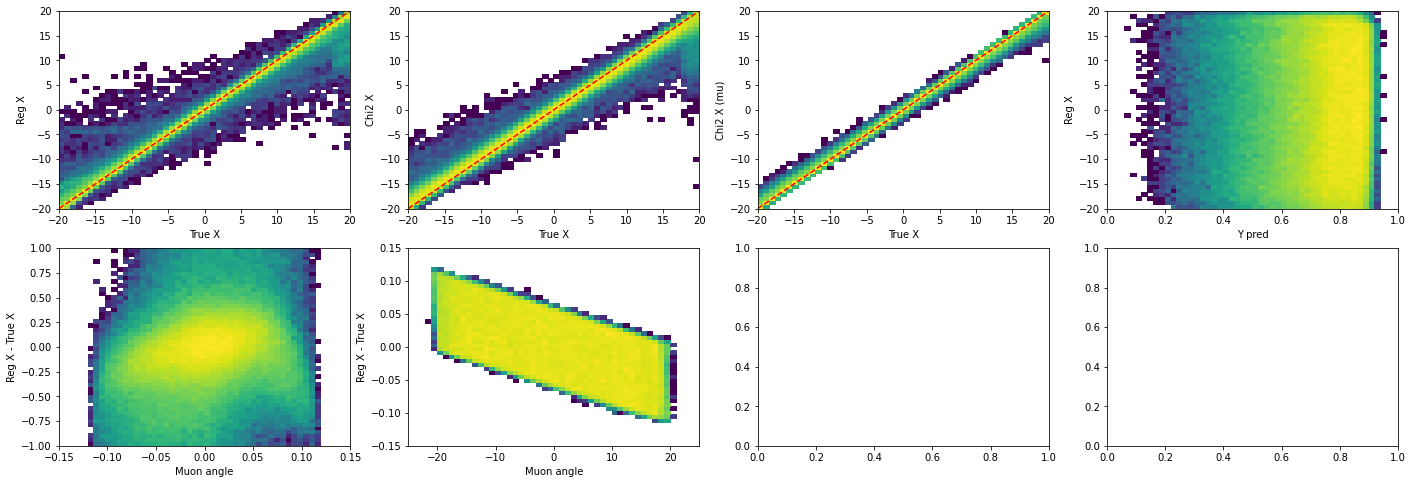

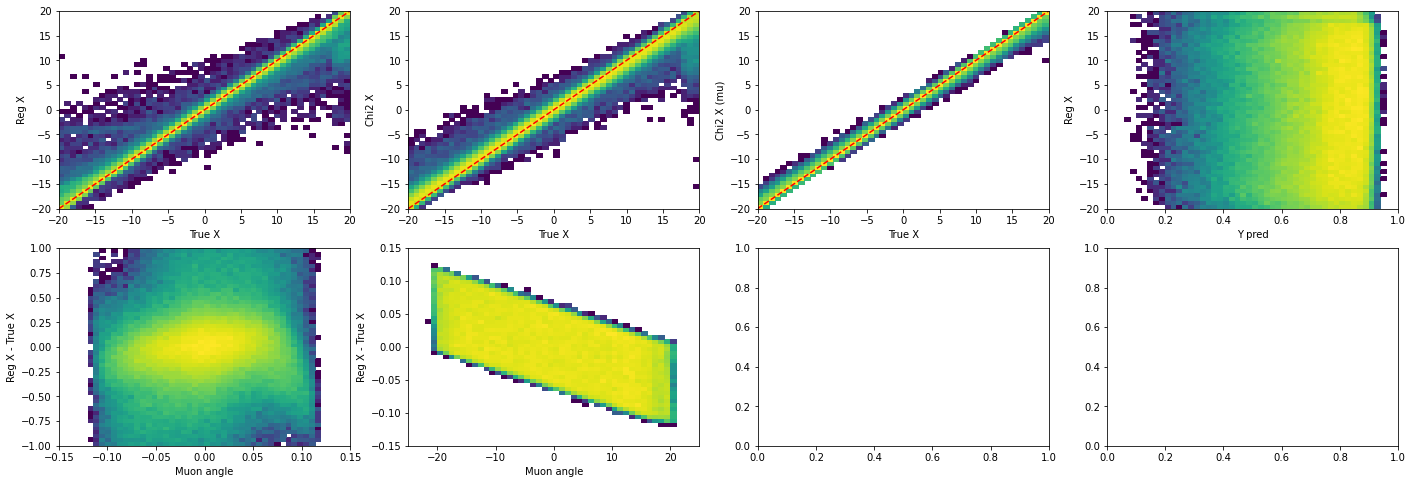

In [34]:
for mod in mdict:
    
    ncols, nrows = (4,2)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    
    this_cut=(Y_mu==1)
    
    axs[0].hist2d( data['ev_mu_x'][this_cut], 
                   mdict[mod]['x_reg'][this_cut], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[0].set_xlabel('True X')
    axs[0].set_ylabel('Reg X')
    axs[0].plot([-20,20],[-20,20], 'r--')
    
    axs[1].hist2d( data['ev_mu_x'][this_cut], 
                   lfits[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[1].set_xlabel('True X')
    axs[1].set_ylabel('Chi2 X')
    axs[1].plot([-20,20],[-20,20], 'r--')
    
    axs[2].hist2d( data['ev_mu_x'][this_cut], 
                   lfits_mu[this_cut][:,1], 
                  range=((-20,20),(-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm())
    axs[2].set_xlabel('True X')
    axs[2].set_ylabel('Chi2 X (mu)')
    axs[2].plot([-20,20],[-20,20], 'r--')
    
    axs[3].hist2d(mdict[mod]['yhat'][this_cut], 
                  mdict[mod]['x_reg'][this_cut],
                  range=((0.0,1), (-20,20)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[3].set_xlabel('Y pred')
    axs[3].set_ylabel('Reg X')
    
    axs[4].hist2d(data['ev_mu_theta'][this_cut],
                  mdict[mod]['x_reg'][this_cut] - data['ev_mu_x'][this_cut], 
                  range=((-0.15, 0.15), (-1,1)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[4].set_xlabel('Muon angle')
    axs[4].set_ylabel('Reg X - True X')
    
    if 'a_reg' in mdict[mod]:
        
        axs[5].hist2d(mdict[mod]['x_reg'][this_cut],
                      mdict[mod]['a_reg'][this_cut], 
                      range=((-25,25), (-0.15,0.15)),
                    bins=(50,50),norm=mpl.colors.LogNorm() )
        axs[5].set_xlabel('Muon angle')
        axs[5].set_ylabel('Reg X - True X')
    
    plt.savefig(f"plots/{mod}_reg_2d.pdf")
    plt.show()